In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime
from textblob import TextBlob

In [4]:
posts_file_path = os.path.join('..', 'data', 'raw', "TheRedPill_weeks_52.json")
posts_df = pd.read_json(posts_file_path)

In [5]:
pd.set_option('display.max_columns', None)
posts_df.head(n=5)

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,awarders,can_mod_post,contest_mode,created_utc,domain,full_link,gildings,id,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_css_class,link_flair_richtext,link_flair_template_id,link_flair_text,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,pwls,retrieved_on,score,selftext,send_replies,spoiler,steward_reports,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,thumbnail,title,total_awards_received,updated_utc,url,whitelist_status,wls,author_flair_background_color,author_flair_text_color,thumbnail_height,thumbnail_width,media,media_embed,post_hint,preview,secure_media,secure_media_embed,banned_by,author_cakeday,edited,media_metadata,author_created_utc,author_flair_template_id,category,content_categories,gilded,removal_reason,suggested_sort,archived,can_gild,distinguished,hidden,quarantine,subreddit_name_prefixed,crosspost_parent,crosspost_parent_list,author_premium,treatment_tags,upvote_ratio
0,[],0.0,Gavin-Sangria,None,[],None,text,t2_4jylj5mz,0.0,[],False,False,1569559102,self.TheRedPill,https://www.reddit.com/r/TheRedPill/comments/d...,{},d9vf4l,False,False,False,False,0.0,True,False,,bp,"[{'e': 'text', 't': 'Blue Pill Example'}]",f656786c-9009-11e2-8e87-12313d183eb5,Blue Pill Example,dark,richtext,False,False,True,0,0,False,no_ads,/r/TheRedPill/comments/d9vf4l/blue_pulled_cele...,False,0.0,1569559103,1,[removed],True,False,[],False,TheRedPill,t5_2ve1u,0,public,self,"Blue pulled celebrities who wasted their smv, ...",0.0,1.569645e+09,https://www.reddit.com/r/TheRedPill/comments/d...,no_ads,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],0.0,treehugger195050,None,[],None,text,t2_2w4t467n,0.0,[],False,False,1569551940,self.TheRedPill,https://www.reddit.com/r/TheRedPill/comments/d...,{},d9u5ql,False,False,False,False,0.0,True,False,,NaN,[],NaN,NaN,dark,text,False,False,True,2,0,False,no_ads,/r/TheRedPill/comments/d9u5ql/need_help_in_bet...,False,0.0,1569551942,1,[removed],True,False,[],False,TheRedPill,t5_2ve1u,0,public,self,Need Help - In Beta Male LDR with Filipina,0.0,1.569638e+09,https://www.reddit.com/r/TheRedPill/comments/d...,no_ads,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],0.0,BFlocka,None,[],None,text,t2_pfd86,0.0,[],False,False,1569551575,self.TheRedPill,https://www.reddit.com/r/TheRedPill/comments/d...,{},d9u37g,False,False,False,False,1.0,True,False,,NaN,[],NaN,NaN,dark,text,False,False,True,10,0,False,no_ads,/r/TheRedPill/comments/d9u37g/just_had_to_swal...,False,0.0,1569551576,0,"I’m 23, first year out of college, gf is also ...",True,False,[],False,TheRedPill,t5_2ve1u,0,public,self,Just had to swallow a massive redpill tonight ...,0.0,1.569638e+09,https://www.reddit.com/r/TheRedPill/comments/d...,no_ads,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],0.0,Ragomai,None,[],None,text,t2_fgfrn,0.0,[],False,False,1569550482,self.TheRedPill,https://www.reddit.com/r/TheRedPill/comments/d...,{},d9tvxf,False,False,False,False,1.0,True,False,,unflaired,[],NaN,NaN,dark,text,False,False,True,8,0,False,no_ads,/r/TheRedPill/comments/d9tvxf/when_it_actually...,False,0.0,1569550484,2,i've always known in the back of my mind that ...,True,False,[],False,TheRedPill,t5_2ve1u,0,public,self,"When it actually hits you how accurate RP is, ...",0.0,1.569637e+09,https://www.reddit.com/r/TheRedPill/comments/d...,no_ads,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [6]:
posts_df['created_date'] = pd.to_datetime(
    posts_df['created_utc'].apply(
        lambda x: None if np.isnan(x) else datetime.fromtimestamp(x)),
    errors='coerce')

posts_df['created_date'] = posts_df['created_date'].dt.date

In [7]:
print(posts_df.created_date.min())
print(posts_df.created_date.max())

2018-08-11
2019-09-26


In [8]:
posts_df.set_index('created_date', inplace=True)

In [9]:
# posts_df['post_type'] = posts_df['selftext'].apply(lambda x: (x not in ['[removed]', '']) & (~pd.isnull(x)))
posts_df['post_type'] = np.select(
    [
        posts_df['selftext'] == '[removed]', 
        posts_df['selftext'] == '[deleted]', 
        posts_df['selftext'] == '',
        pd.isna(posts_df['selftext']) 
    ], 
    [
        'removed', 
        'deleted',
        'blank',
        'nan'
    ], 
    default='extant'
)
posts_df[['post_type', 'selftext']]

,post_type,selftext
created_date,,
2019-09-26,removed,[removed]
2019-09-26,removed,[removed]
2019-09-26,extant,"I’m 23, first year out of college, gf is also ..."
2019-09-26,extant,i've always known in the back of my mind that ...
2019-09-26,extant,"So after a breakup, I took the redpill and it ..."
...,...,...
2018-08-11,nan,NaN
2018-08-11,nan,NaN
2018-08-11,removed,[removed]


In [10]:
posts_df.groupby('post_type')['post_type'].count() #majority are either removed or blank... need to investigate this for sure

post_type
blank       758
deleted      48
extant     2007
nan          75
removed    2485
Name: post_type, dtype: int64

In [11]:
#again a huge proportion are blank... the subreddit is banned so technically none of them are publically visible anymore, is this posts that were removed prior to being banned?
posts_by_date = posts_df.groupby('created_date')['post_type'].value_counts().unstack()
posts_by_date.fillna(0, inplace=True)
posts_by_date.head()

post_type,blank,deleted,extant,nan,removed
created_date,,,,,
2018-08-11,0.0,0.0,6.0,10.0,10.0
2018-08-12,0.0,0.0,11.0,0.0,14.0
2018-08-13,1.0,0.0,23.0,0.0,30.0
2018-08-14,0.0,0.0,12.0,0.0,19.0
2018-08-15,0.0,0.0,14.0,0.0,24.0


<AxesSubplot:xlabel='created_date'>

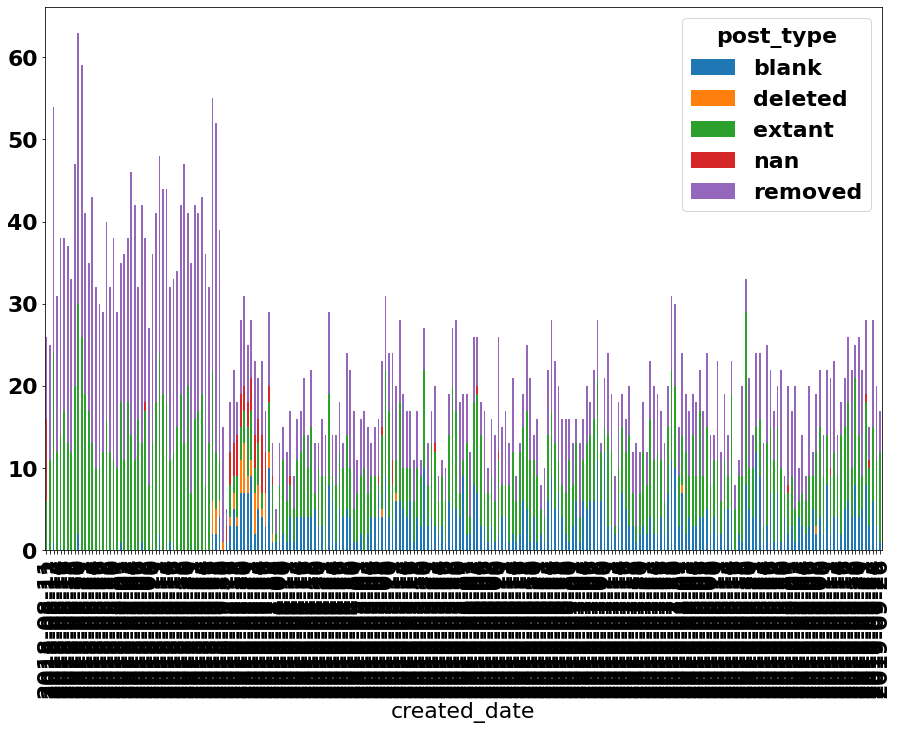

In [13]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}
# mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = (15,10)
posts_by_date.plot(kind='bar', stacked=True)

In [2]:
extant_posts = posts_df[posts_df['post_type'] == 'extant']
extant_posts['selftext']

NameError: name 'posts_df' is not defined

In [10]:
curses = TextBlob('Fuck this bullshit. People are assholes and everything they say doesnt mean shit.')
negative_subjective = TextBlob('I hate everything and everything sucks. Everyone is out to get me and its not fair, waaaaaaa')
negative_objective = TextBlob('Country has recorded more than 390,000 new infections and 3,689 deaths over the past 24-hour period')
positive_subjective = TextBlob('I love everything and everything is great. Everyone loves me and and the sun is shining')
positive_objective = TextBlob('Country has added more than 390,000 new jobs and GDP has increased 3 percent per year for a decade')

(curses.sentiment, negative_subjective.sentiment, negative_objective.sentiment, positive_subjective.sentiment, positive_objective.sentiment)

(Sentiment(polarity=-0.3041666666666667, subjectivity=0.6958333333333334),
 Sentiment(polarity=-0.4833333333333334, subjectivity=0.7000000000000001),
 Sentiment(polarity=0.12878787878787878, subjectivity=0.40151515151515155),
 Sentiment(polarity=0.65, subjectivity=0.675),
 Sentiment(polarity=0.3181818181818182, subjectivity=0.4772727272727273))

Polarity ranges from (-1, 1) and subjectivity from (0, 1), so not sure about the ranges but in general the sentiment seems to track relatively well - the negative ones are very different from the positive, but swear words don't seem to immediately indicate negativity - we'll see if thats an issue. Now let's get a post_length feature and polarity/sentiment for each post, so that we can see the extremes in TRP and see if it makes any sense. 

In [11]:
# sentiment_test = extant_posts.loc[:, ['selftext','log_nword']]
sentiment_test = pd.DataFrame(extant_posts.loc[:,'selftext'].apply(lambda text: tuple(TextBlob(text).sentiment)).tolist())

In [12]:
sentiment_test.index = extant_posts.index
sentiment_test['selftext'] = extant_posts['selftext']
sentiment_test.loc[:,'log10_nword'] = sentiment_test.loc[:,'selftext'].apply(lambda x: math.log10(len(x.split())))
sentiment_test.rename(columns = {0:'sentiment', 1:'objectivity'}, inplace = True)


In general the short posts seem pretty unreliable - let's see if there is a difference among longer posts, like 250 words or more (the long explainer-type posts ideally).

In [13]:
sentiment_test_long = sentiment_test[sentiment_test['log10_nword'] > math.log10(250)]

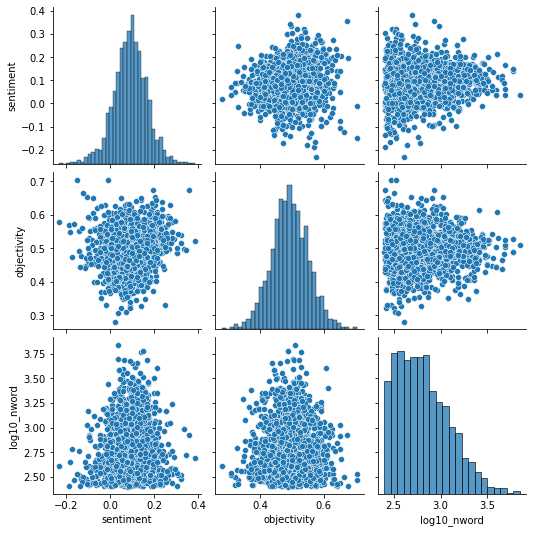

In [14]:
sns.pairplot(sentiment_test_long)

Just as we all expected, TRP is generally positive according to textblob. Let's get some of the extreme examples and see what's up. Unsurprisingly, posts with more words are less ambigious in terms of both sentiment and objectivity, so those will probably be most useful to us.  

In [1]:
#high objectivity
sentiment_test_long.sort_values('objectivity' , ascending= False).head(10).apply(lambda row: print(str(row['objectivity']) + ': ' + row['selftext'] + '\n'), axis= 1)

NameError: name 'sentiment_test_long' is not defined

In [16]:
#high sentiment
sentiment_test_long.sort_values('sentiment' , ascending= False).head(5).apply(lambda row: print(str(row['sentiment']) + ': ' + row['selftext'] + '\n'), axis= 1)

0.3833333333333333: With the help of [my archive](http://archive.ph/PaUW8), I gathered the top 1000 most upvoted posts made on TheRedPill subreddit and converted them into PDF files.

* **Preview:** https://i.imgur.com/Bpq6dFF.gifv

* **Download:** [TheRedPill - Top 1000 Upvoted Posts.zip](https://www.zeta-uploader.com/1668521147) ([Virustotal](https://www.virustotal.com/gui/file/aa3abaa8df6dc442f990a0dcf181b75926837a3642ca07bcf426f31b83d3485f))

* You can browse the entire collection on Google Drive [here](https://drive.google.com/open?id=1ANi5UkB4m5PfC9VuAOGuv9pokiITzKqt).

I hope you guys enjoy, keep and redistribute this - so if this subreddit ever gets banned, everyone has a backup of the gold.

Enjoy &amp; cheers.

Lorem ipsum dolor sit amet, consectetur adipiscing elit. In cursus tellus vel neque maximus gravida. Vivamus dignissim lorem sed ultricies ullamcorper. Sed eget tempus neque. Maecenas tempor, leo id auctor mollis, enim nibh sagittis mi, a pretium augue urna at nulla. A

created_date
2019-08-19    None
2018-08-25    None
2018-08-23    None
2018-09-15    None
2019-09-17    None
dtype: object

In [17]:
#low objectivity
sentiment_test_long.sort_values('objectivity' , ascending= True).head(5).apply(lambda row: print(str(row['objectivity']) + ': ' + row['selftext'] + '\n'), axis= 1)

0.2803009883198562: Essay:

[https://therationalmale.com/2019/02/27/the-global-sexual-marketplace/](https://therationalmale.com/2019/02/27/the-global-sexual-marketplace/)

&amp;#x200B;

Excerpt:

&amp;#x200B;

**A Modern SMP**

In an upcoming essay I’ll be exploring the deeper reasons why Blank-Slate Equalism is so difficult to purge from our present-day social order. However, I need to detail a bit of this now. We live in a feminine-primary social order (the Gynocracy), but without the Blank-Slate much of the preconception of it collapse. One reason Blank-Slate Equalism remains a social norm (despite a world of empirical proof that destroys it) is because it serves to disguise the ugly realities of a sexual marketplace defined by human evolution. Particularly so in an age of expanding SMP globalism. It’s not just culture, politics, ideology and socioeconomic considerations that are tied to globalization; a global scale sexual marketplace is following among all of this.

In the age of 

created_date
2019-02-27    None
2018-09-12    None
2018-09-18    None
2018-09-22    None
2019-05-02    None
dtype: object

In [18]:
#low sentiment
sentiment_test_long.sort_values('sentiment' , ascending= True).head(5).apply(lambda row: print(str(row['sentiment']) + ': ' + row['selftext'] + '\n'), axis= 1)

-0.2303125: There is this whole subreddit dedicated to bashing hardworking guys who have wives and girlfriends who do not work.  [https://www.reddit.com/r/breakingmom](https://www.reddit.com/r/breakingmom) 

I went over and read a few posts trying to understand why why my gf is so pissed off at me after I saw she was reading it and its all man bashing.  Then I was immediately banned even though I never posted anything, commented anything, or liked anything, I was just reading looking for my gf's post.  I didn't interact in any way and I was banned.

I work hard, the shop is not air conditioned, and its June and hot as hell.  Add to that I'm wearing welding gear sometimes.  Add to that Boss man is always pushing to get stuff done faster and it can be stressful when you got some crazy problems to solve that involve cutting out the busted steal parts, making a template, and welding in and reinforcing frames etc.  

I get home and all I want to do is take a shower, and maybe do some gaming

created_date
2019-06-28    None
2019-09-20    None
2019-06-17    None
2019-04-21    None
2019-04-21    None
dtype: object

In general the short posts seem pretty unreliable - let's see if there is a difference among longer posts, like 250 words or more (the long explainer-type posts ideally).